In [1]:
import pandas as pd
import numpy as np
from random import randint
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import time

df_train = pd.read_csv("train_users_2.csv")
df_test = pd.read_csv('test_users.csv')
df_sessions = pd.read_csv('sessions.csv')



In [2]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [4]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [5]:
def encodeDate(df_train):
    df_train['date_account_created']=pd.to_datetime(df_train['date_account_created']).dt.dayofweek
    df_train['date_first_booking']=pd.to_datetime(df_train['date_first_booking']).dt.dayofweek
    df_train['year_account_created'] = pd.DatetimeIndex(df_train['date_account_created']).year
    df_train['month_account_created'] = pd.DatetimeIndex(df_train['date_account_created']).month
    df_train['date_first_active'] = pd.to_datetime(df_train['timestamp_first_active'], format='%Y%m%d%H%M%S')
    df_train['day_account_created'] = pd.DatetimeIndex(df_train['date_account_created']).day
    date_first_active = pd.DatetimeIndex(df_train['date_first_active'])
    df_train['day_first_active'] = date_first_active.day
    df_train['weekday_first_active'] = date_first_active.weekday
    df_train['week_first_active'] = date_first_active.week
    df_train['month_first_active'] = date_first_active.month
    df_train['year_first_active'] = date_first_active.year
    #df['time_lag'] = ( date_account_created.values - date_first_active.values).astype(int)
   
    return df_train

In [6]:
y_des = df_train['country_destination'].values


In [7]:
#X_train = df_train
#X_test = df_test
df_train = df_train.drop(['date_first_booking','country_destination'], axis=1)
df_test = df_test.drop(['date_first_booking'], axis=1)



In [8]:

#df=pd.concat((X_train, X_test), axis=0, ignore_index=True)
#df.shape

In [9]:
print(df_test.shape[0], "Users in Test", df_train.shape[0], "Users in train")

print("Test Users + Training Users = ", df_test.shape[0] + df_train.shape[0])

62096 Users in Test 213451 Users in train
Test Users + Training Users =  275547


In [10]:
len(df_train[df_train['age'].isnull()])

87990

In [11]:


#df_train["age"].fillna(df_train["age"].mean(), inplace=True)

In [12]:
#Fill NA/NaN values using the specified method

#df_train.fillna(method='pad').head()


# find all the missing values(empty,unknown,other ...) and replace it with NaN
def findNA(df_train):
    df_train = df_train.replace(r'\s+', np.nan, regex=True)
    df_train = df_train.replace('-unknown-',np.nan, regex=False)
    df_train = df_train.replace('Other/Unknown',np.nan, regex=False)
    df_train = df_train.dropna(thresh=11) #Ignore the rows with majority Missing Value during Analysis
    return df_train

In [13]:
df_train.head()


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [14]:
# missing data

#df.gender.replace('-unknown-', np.nan, inplace=True)
#df.first_browser.replace('-unknown-', np.nan, inplace=True)

#df.drop('date_first_booking', axis=1, inplace=True)

#df.isnull().sum()

In [15]:
df_train.loc[df_train['age']>1000]['age'].describe()
df_train.loc[df_train['age']<17]['age'].describe()
df_train['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [16]:
df_with_year = df_train['age'] > 1000
df_train.loc[df_with_year, 'age'] = 2015 - df_train.loc[df_with_year, 'age']
df_train.loc[df_train.age > 95, 'age'] = np.nan
df_train.loc[df_train.age < 17, 'age'] = np.nan
df_train['age'].describe()

count    122961.000000
mean         36.528054
std          11.585880
min          17.000000
25%          28.000000
50%          34.000000
75%          42.000000
max          95.000000
Name: age, dtype: float64

In [17]:
def missing_values_Helper(pairs):  
    total = sum(pair[0] for pair in pairs)
    r = randint(1, total)
    for (weight, value) in pairs:
        r -= weight
        if r <= 0: return value

In [18]:
#Fill NA/NaN values of age using mean

df_train.loc[df_train.age.isnull(), 'age']=df_train.age.mean()

In [19]:
#Split Date Acount Create

dac = np.vstack(
    df_train.date_account_created.astype(str).apply(
        lambda x: list(map(int, x.split('-')))
    ).values
)
df_train['dac_year'] = dac[:, 0]
df_train['dac_month'] = dac[:, 1]
df_train['dac_day'] = dac[:, 2]
df_train = df_train.drop(['date_account_created'], axis=1)
df_train.head()

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day
0,gxn3p5htnn,20090319043255,-unknown-,36.528054,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28
1,820tgsjxq7,20090523174809,MALE,38.000000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25
2,4ft3gnwmtx,20090609231247,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28
3,bjjt8pjhuk,20091031060129,FEMALE,42.000000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5
4,87mebub9p4,20091208061105,-unknown-,41.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14


In [20]:
tfa = np.vstack(
    df_train.timestamp_first_active.astype(str).apply(
        lambda x: list(map(int, [x[:4], x[4:6], x[6:8],
                                 x[8:10], x[10:12],
                                 x[12:14]]))
    ).values
)
df_train['tfa_year'] = tfa[:, 0]
df_train['tfa_month'] = tfa[:, 1]
df_train['tfa_day'] = tfa[:, 2]
df_train = df_train.drop(['timestamp_first_active'], axis=1)

In [21]:
def missing_values_imputation(df):

    for col in df:
        nan_count=df[col].isnull().sum()
        if col=='age':
            df=handle_outlier_age(df)
                    # For parameters other then age, impute their missing value using stratified methodology of missing value imputation    
        if nan_count>0 and col!='age': 
            df_counts=df[col].value_counts()
            Total_minus_unknown = 0
            Total_minus_unknown = len(df[col]) - len(df_counts)
            ratio_list=[]

            for i in range(len(df_counts)):
               
              try:
                ratio_list.append(float(df_counts[i])*100/float(Total_minus_unknown))
                min_ratio = min(ratio_list)
                ratio_list = [int(x/min_ratio) for x in ratio_list]
                counts_list=df_counts.index.tolist()
                pairs = list(zip(ratio_list,counts_list))
                df[col]=df[col].apply(lambda x: missing_values_Helper(pairs) if(pd.isnull(x)) else x)
            ################################################ 
              except KeyError:
                    print(f'a problem')        
           #################################################
       
       # Creating bins for signup_flow parameter

        if col=='signup_flow':
            bins = [-1,5,10,15,20,28]
            group_names = [0,1,2,3,4]
            df['signup_flow_bins'] = pd.cut(df['signup_flow'], bins, labels=group_names)

    return df

In [22]:

df1 = df_sessions.user_id.value_counts()
print(df1.shape)


(135483,)


In [23]:
df1.head()

mxqbh3ykxl    2722
0hjoc5q8nf    2644
mjbl6rrj52    2476
l5lgm3w5pc    2424
wg9413iaux    2362
Name: user_id, dtype: int64

In [24]:
df1 = df1.to_frame()
df1 = df1.rename(columns = {'user_id' : 'session_count'})
df1['id'] = df1.index
df1.head()

,session_count,id
mxqbh3ykxl,2722,mxqbh3ykxl
0hjoc5q8nf,2644,0hjoc5q8nf
mjbl6rrj52,2476,mjbl6rrj52
l5lgm3w5pc,2424,l5lgm3w5pc
wg9413iaux,2362,wg9413iaux


In [25]:
df = pd.merge(df_train, df1, how = 'left', on = ['id'])
df.session_count.fillna(0, inplace = True)
df.session_count = df.session_count.astype(int)

### One-Hot-Encoding

In [26]:
#Categorical Variables

oh_features = ['gender', 'signup_method', 'signup_flow', 'language',
                'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app',
                'first_device_type', 'first_browser']

In [27]:


#One-Hot-Encoding and Dummy Variable Trap

for feature in oh_features:
    df_dummy = pd.get_dummies(df[feature], prefix=feature)
    df = df.drop([feature], axis=1)
    df = pd.concat((df, df_dummy), axis=1)
df.head(10)

,id,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,session_count,gender_-unknown-,...,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,gxn3p5htnn,36.528054,2010,6,28,2009,3,19,0,1,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,38.000000,2011,5,25,2009,5,23,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,56.000000,2010,9,28,2009,6,9,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,42.000000,2011,12,5,2009,10,31,0,0,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,41.000000,2010,9,14,2009,12,8,0,1,...,0,0,0,0,0,0,0,0,0,0
5,osr2jwljor,36.528054,2010,1,1,2010,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,lsw9q7uk0j,46.000000,2010,1,2,2010,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0d01nltbrs,47.000000,2010,1,3,2010,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
8,a1vcnhxeij,50.000000,2010,1,4,2010,1,4,0,0,...,0,0,0,0,0,0,0,0,0,0
9,6uh8zyj2gn,46.000000,2010,1,4,2010,1,4,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
list(df)


['id',
 'age',
 'dac_year',
 'dac_month',
 'dac_day',
 'tfa_year',
 'tfa_month',
 'tfa_day',
 'session_count',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'gender_OTHER',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_method_google',
 'signup_flow_0',
 'signup_flow_1',
 'signup_flow_2',
 'signup_flow_3',
 'signup_flow_4',
 'signup_flow_5',
 'signup_flow_6',
 'signup_flow_8',
 'signup_flow_10',
 'signup_flow_12',
 'signup_flow_15',
 'signup_flow_16',
 'signup_flow_20',
 'signup_flow_21',
 'signup_flow_23',
 'signup_flow_24',
 'signup_flow_25',
 'language_ca',
 'language_cs',
 'language_da',
 'language_de',
 'language_el',
 'language_en',
 'language_es',
 'language_fi',
 'language_fr',
 'language_hr',
 'language_hu',
 'language_id',
 'language_is',
 'language_it',
 'language_ja',
 'language_ko',
 'language_nl',
 'language_no',
 'language_pl',
 'language_pt',
 'language_ru',
 'language_sv',
 'language_th',
 'language_tr',
 'language_zh',
 'affiliate_channel_api',


In [29]:
#split the well processed dataset into X_train and X_test
X_train = df.iloc[:len(df_train), :]
X_test = df.iloc[len(df_test):, :]
X_train = X_train.drop(['id'], axis=1)
X_train.shape
X_test = X_test.drop(['id'], axis=1)
X_test.shape

(151355, 155)

In [30]:
# label encoding the data

from sklearn.preprocessing import LabelEncoder 
  

le = LabelEncoder()
y_trans = le.fit_transform(y_des)
y_trans.shape

#le_test = LabelEncoder()
#y_test = le.fit_transform(***)
#y_test.shape



(213451,)

In [31]:
from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(...     X, y, test_size=0.33, random_state=42)



dtrain, dtest, train_label, test_label = train_test_split(X_train, y_trans, test_size = 0.3, random_state = 5)




### Logistic Regression

In [32]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Logistic Regression - OVR

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logr = LogisticRegression()
logr.fit(dtrain, train_label)

logr_test = LogisticRegression()
logr_test.fit(dtest, test_label)


pred_log_train=logr.predict(dtrain)
print(accuracy_score(train_label, pred_log_train))


pred_log_test=logr_test.predict(dtest)
print(accuracy_score(test_label, pred_log_test))


0.604818793293846
0.6039103004559935


In [33]:
# Logistic Regression - Multinomial

#from sklearn.linear_model import LogisticRegression

#logr_mlt = LogisticRegression(n_jobs=1,multi_class='multinomial',solver='newton-cg')
#logr_mlt.fit(dtrain, train_label)



In [34]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=20, n_estimators=100)
rfc.fit(dtrain , train_label)
pred = rfc.predict(dtest)
print(accuracy_score(test_label, pred))



0.6221031919545256


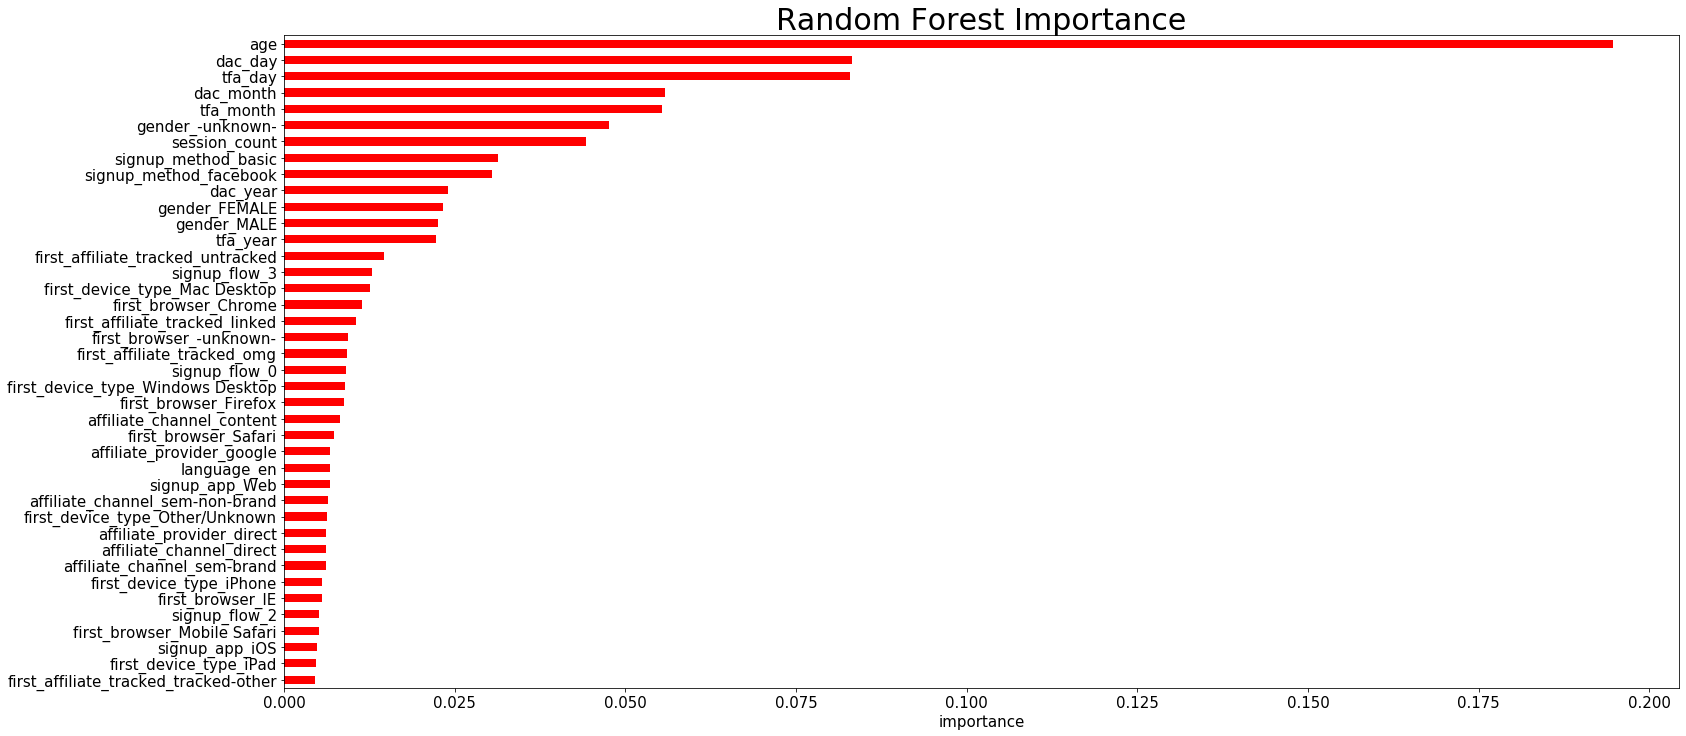

In [35]:
fi=pd.Series(rfc.feature_importances_, index=dtrain.columns)
fn=fi.sort_values(ascending=True)
fn[-40:].plot(kind='barh', color='r', figsize=(25, 12))
plt.xlabel('importance', size=15)
plt.title('Random Forest Importance', size=30)
plt.tick_params(labelsize=15)

In [36]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(dtrain , train_label)
pred = dtc.predict(dtest)
print(accuracy_score(test_label, pred))

0.6281935161471672
